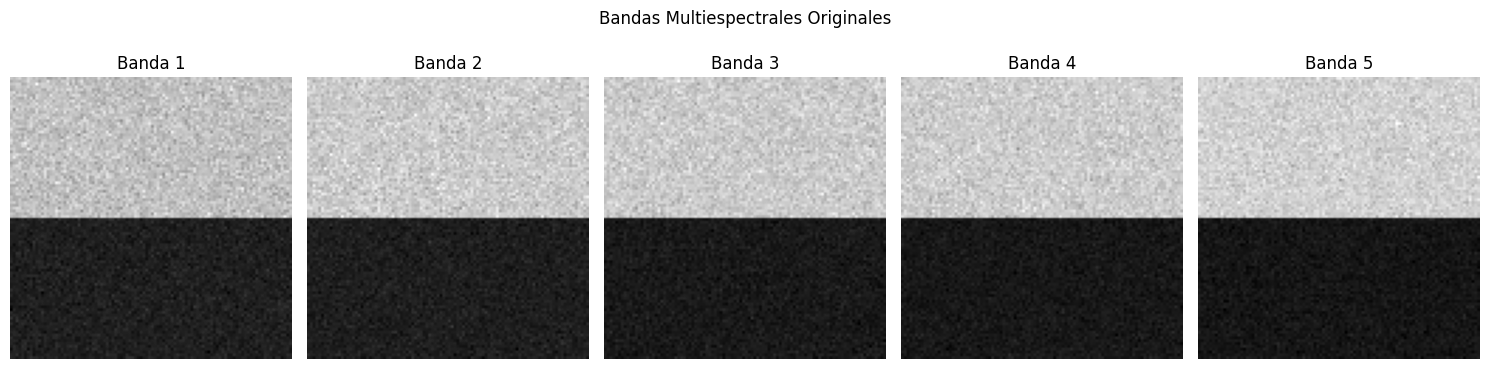

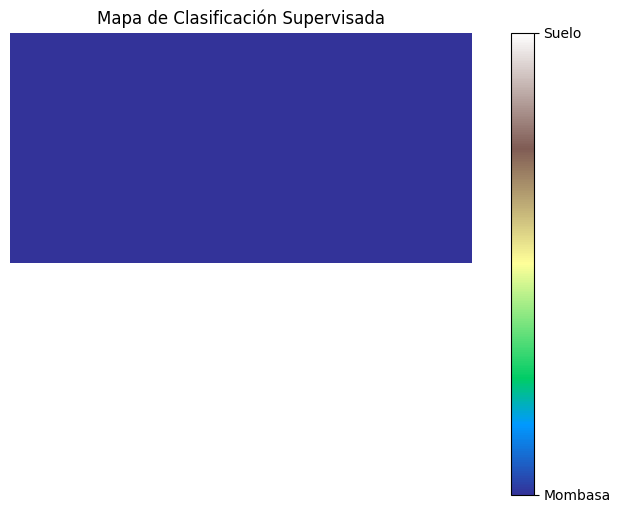

In [3]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# --- 1. Datos de entrenamiento simulados (5 bandas) ---
X = np.array([
    [0.12, 0.18, 0.25, 0.32, 0.04],  # Mombasa
    [0.11, 0.17, 0.26, 0.30, 0.03],
    [0.03, 0.05, 0.08, 0.12, 0.02],  # Suelo
    [0.02, 0.04, 0.07, 0.11, 0.01],
    [0.10, 0.16, 0.21, 0.29, 0.04],  # Mombasa
    [0.04, 0.06, 0.09, 0.13, 0.02]   # Suelo
])
y = ['Mombasa', 'Mombasa', 'Suelo', 'Suelo', 'Mombasa', 'Suelo']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# --- 2. Cargar imagen multibanda ---
ruta_imagen = "imagen_multibanda.tif"

with rasterio.open(ruta_imagen) as src:
    img = src.read()  # (bandas, filas, columnas)
    profile = src.profile

# Transponer a (filas, columnas, bandas)
img = np.transpose(img, (1, 2, 0))  # (H, W, B)
h, w, b = img.shape

# --- Visualizar las 5 bandas ---
fig, axes = plt.subplots(1, b, figsize=(15, 4))
for i in range(b):
    band_data = img[:, :, i]
    axes[i].imshow(band_data, cmap='gray')
    axes[i].set_title(f'Banda {i+1}')
    axes[i].axis('off')
plt.suptitle('Bandas Multiespectrales Originales')
plt.tight_layout()
plt.show()

# --- 3. Aplanar imagen y predecir ---
pixels = img.reshape(-1, img.shape[2])
valid_mask = np.all(np.isfinite(pixels) & (pixels > 0), axis=1)
valid_pixels = pixels[valid_mask]

predicted_labels = clf.predict(valid_pixels)

# --- 4. Reconstruir imagen clasificada ---
label_map = np.full(pixels.shape[0], "Desconocido", dtype=object)
label_map[valid_mask] = predicted_labels

class_names = sorted(set(y))
class_to_id = {name: i+1 for i, name in enumerate(class_names)}
numeric_labels = np.array([class_to_id.get(label, 0) for label in label_map])
classified_image = numeric_labels.reshape(h, w)

# --- 5. Guardar imagen clasificada ---
output_path = "clasificacion.tif"
profile.update(dtype='uint8', count=1)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(classified_image.astype('uint8'), 1)

# --- 6. Visualizar clasificación ---
plt.figure(figsize=(10, 6))
plt.imshow(classified_image, cmap='terrain')
cbar = plt.colorbar(ticks=list(class_to_id.values()))
cbar.ax.set_yticklabels(list(class_to_id.keys()))
plt.title("Mapa de Clasificación Supervisada")
plt.axis('off')
plt.show()



